<span style='font-size: 200%; font-weight: bold; color: #45AED6;'>Python: using OpenStudio Bindings, EnergyPlus API, and matplotlib</span>

<p style="font-size: 130%; font-weight: bold; font-family: 'Roboto', sans-serif;">Written By Julien Marrec of <a href="https://effibem.com"><span style="color: #45AED6;">EffiBEM</span></a>, circa 2021-01-05</p>

# Purpose

This notebook aims to demonstrate the use of:

* **The OpenStudio Python Bindings**.
    * This is used to efficiently create and customize a model to be simulated

    * **Note**: Until a version > 3.1.0 (eg 3.1.1 or 3.2.0) is out on [**pypi**](https://pypi.org/project/openstudio/), I recommend using the [**testpypi**](https://test.pypi.org/project/openstudio/) version where I made usability adjustments. You can do `pip install -i https://test.pypi.org/simple/ openstudio` for that one.
    
    
* **The EnergyPlus Python API**, and how to use callbacks to retrieve data

* **Updating a live matplotlib plot during E+ simulation** via the EnergyPlus Python API callback.


Several options and examples are shown below. **I strongly recommend you encapsulate your data inside a class** (see section 3.4) instead of relying on python `global` data, but it does bring a sligthly higher complexity level so for simple stuff you can ommit that and use 3.1 to 3.3 instead (which are also used as an entry point to demonstrate the API)

----

**Resources:**

* OpenStudio SDK documentation: https://openstudio-sdk-documentation.s3.amazonaws.com/index.html
* EnergyPlus Python API documentation: https://energyplus.readthedocs.io/en/latest/api.html

![](images/interactive_plot.gif)

# Top level imports

In [1]:
%matplotlib notebook
# or nbagg

In [2]:
import os
import shutil
import sys
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# Clean up artifacts (optional)
if os.path.exists('test.idf'):
    os.remove('test.idf')
    
if os.path.exists('out/'):
    shutil.rmtree('out/')

# Use OpenStudio to create a Model

In [4]:
import openstudio

In [5]:
# For reproducibility, here are the versions I used to create and run this notebook
_s = !pip list
print(f"Pip package used initially: {[x for x in _s if 'openstudio' in x][0]}")
print(f"OpenStudio Long Version:    {openstudio.openStudioLongVersion()}")

Pip package used initially: openstudio                        3.1.1a15
OpenStudio Long Version:    3.1.1-alpha+70eedb538e


## Create an example model

This is an openstudio built in example model, which is a shoebox with 4 spaces inside a single thermal zone.

If you are curious to see what the model contains, refer to the source code here in [Model.cpp#L1333](https://github.com/NREL/OpenStudio/blob/f4ba8ce3dbce2338589fb8a28979cd30d8ed0fe9/src/model/Model.cpp#L1333) (or use the [OpenStudioApplication](https://github.com/openstudiocoalition/OpenStudioApplication) to browse it)

In [6]:
m = openstudio.model.exampleModel()

## Set output variables

We remove all existing ones (the `exampleModel()` creates a few), and add a few we care about

In [7]:
[x.remove() for x in m.getOutputVariables()]

[(<openstudio.openstudioutilitiesidf.IdfObject; proxy of <Swig Object of type 'openstudio::IdfObject *' at 0x7f546fa042d0> >,),
 (<openstudio.openstudioutilitiesidf.IdfObject; proxy of <Swig Object of type 'openstudio::IdfObject *' at 0x7f546fa048d0> >,),
 (<openstudio.openstudioutilitiesidf.IdfObject; proxy of <Swig Object of type 'openstudio::IdfObject *' at 0x7f546fa049c0> >,),
 (<openstudio.openstudioutilitiesidf.IdfObject; proxy of <Swig Object of type 'openstudio::IdfObject *' at 0x7f546fa04a20> >,)]

In [8]:
o = openstudio.model.OutputVariable("Site Outdoor Air Drybulb Temperature", m)
o.setKeyValue("Environment")
o.setReportingFrequency("Timestep")

True

In [9]:
for var in ["Zone Mean Air Temperature",
            "Zone Thermostat Heating Setpoint Temperature",
            "Zone Thermostat Cooling Setpoint Temperature"]:
    o = openstudio.model.OutputVariable(var, m)
    #o.setKeyValue(openstudio.model.getThermalZones(m)[0].nameString())
    o.setReportingFrequency("Timestep")

In [10]:
[print(x) for x in m.getOutputVariables()]

OS:Output:Variable,
  {c0e5b2e1-5f55-41e0-b1dd-62309d077303}, !- Handle
  Output Variable 4,                      !- Name
  ,                                       !- Key Value
  Zone Thermostat Cooling Setpoint Temperature, !- Variable Name
  Timestep;                               !- Reporting Frequency


OS:Output:Variable,
  {40eb80e2-4fdc-40e4-9aa2-e080c4cdeeaa}, !- Handle
  Output Variable 3,                      !- Name
  ,                                       !- Key Value
  Zone Thermostat Heating Setpoint Temperature, !- Variable Name
  Timestep;                               !- Reporting Frequency


OS:Output:Variable,
  {f227c373-46ac-4125-8d52-9af913a954dd}, !- Handle
  Output Variable 2,                      !- Name
  ,                                       !- Key Value
  Zone Mean Air Temperature,              !- Variable Name
  Timestep;                               !- Reporting Frequency


OS:Output:Variable,
  {fe7ce65f-c35c-451b-8383-f68bd5f9ce43}, !- Handle
  Outpu

[None, None, None, None]

## Set timestep to 4

In [11]:
timestep = m.getTimestep()
print(timestep)

OS:Timestep,
  {9b9872c1-27db-4cb3-87fc-43b2628b7943}, !- Handle
  6;                                      !- Number of Timesteps per Hour




In [12]:
timestep.setNumberOfTimestepsPerHour(4)
print(timestep)

OS:Timestep,
  {9b9872c1-27db-4cb3-87fc-43b2628b7943}, !- Handle
  4;                                      !- Number of Timesteps per Hour




## Check the heating thermostat schedule

This is unused after, serves as a demo of how the OS SDK API works

In [13]:
z = m.getThermalZones()[0]
t = z.thermostatSetpointDualSetpoint().get()
heating_sch = t.heatingSetpointTemperatureSchedule().get()
o = heating_sch.to_ScheduleRuleset()
if o.is_initialized():
    heating_sch = o.get()
    print(heating_sch.briefDescription())
else:
    print(heating_sch.briefDescription())
#heating_sch = openstudio.model.toScheduleRuleset(heating_sch).get()

Object of type 'OS:Schedule:Ruleset' and named 'Medium Office Heating Setpoint Schedule'


In [14]:
print(heating_sch.defaultDaySchedule())

OS:Schedule:Day,
  {bc2f9235-9880-4bb8-8364-2d5e79cbe2fa}, !- Handle
  Medium Office Heating Setpoint All Other Days Schedule, !- Name
  {9dd62a41-f89d-4834-99b3-4e496043b5a5}, !- Schedule Type Limits Name
  ,                                       !- Interpolate to Timestep
  24,                                     !- Hour 1
  0,                                      !- Minute 1
  15.6;                                   !- Value Until Time 1




In [15]:
[print(x) for x in heating_sch.scheduleRules()]

OS:Schedule:Rule,
  {0dad2926-1f3e-4f11-a51c-99e972bba3cf}, !- Handle
  Medium Office Heating Setpoint Schedule Saturday Rule, !- Name
  {ffb27c65-5e7b-4433-8907-e8543c3fa8e7}, !- Schedule Ruleset Name
  0,                                      !- Rule Order
  {3ad7abfd-2daa-4d10-acc3-c8a3f05adb99}, !- Day Schedule Name
  ,                                       !- Apply Sunday
  ,                                       !- Apply Monday
  ,                                       !- Apply Tuesday
  ,                                       !- Apply Wednesday
  ,                                       !- Apply Thursday
  ,                                       !- Apply Friday
  Yes;                                    !- Apply Saturday


OS:Schedule:Rule,
  {f231912d-410d-4609-8eb5-90d092af77d5}, !- Handle
  Medium Office Heating Setpoint Schedule Weekdays Rule, !- Name
  {ffb27c65-5e7b-4433-8907-e8543c3fa8e7}, !- Schedule Ruleset Name
  1,                                      !- Rule Order
  {16

[None, None]

## Restrict to one month of simulation

In [16]:
r = m.getRunPeriod()
print(r)

OS:RunPeriod,
  {ee1c1160-0e81-4a60-ac03-1c67489fa907}, !- Handle
  Run Period 1,                           !- Name
  1,                                      !- Begin Month
  1,                                      !- Begin Day of Month
  12,                                     !- End Month
  31,                                     !- End Day of Month
  No,                                     !- Use Weather File Holidays and Special Days
  No,                                     !- Use Weather File Daylight Saving Period
  No,                                     !- Apply Weekend Holiday Rule
  Yes,                                    !- Use Weather File Rain Indicators
  Yes,                                    !- Use Weather File Snow Indicators
  1;                                      !- Number of Times Runperiod to be Repeated




In [41]:
r.setEndMonth(1)
r.setEndDayOfMonth(31)

True

In [42]:
print(r)

OS:RunPeriod,
  {ee1c1160-0e81-4a60-ac03-1c67489fa907}, !- Handle
  Run Period 1,                           !- Name
  1,                                      !- Begin Month
  1,                                      !- Begin Day of Month
  2,                                      !- End Month
  28,                                     !- End Day of Month
  No,                                     !- Use Weather File Holidays and Special Days
  No,                                     !- Use Weather File Daylight Saving Period
  No,                                     !- Apply Weekend Holiday Rule
  Yes,                                    !- Use Weather File Rain Indicators
  Yes,                                    !- Use Weather File Snow Indicators
  1;                                      !- Number of Times Runperiod to be Repeated




## Forward translate to IDF

In [43]:
ft = openstudio.energyplus.ForwardTranslator()
w = ft.translateModel(m)
w.save(openstudio.path('test.idf'), True)

True

In [20]:
!grep -A13 RunPeriod test.idf

RunPeriod,
  Run Period 1,                           !- Name
  1,                                      !- Begin Month
  1,                                      !- Begin Day of Month
  2009,                                   !- Begin Year
  1,                                      !- End Month
  31,                                     !- End Day of Month
  2009,                                   !- End Year
  Thursday,                               !- Day of Week for Start Day
  No,                                     !- Use Weather File Holidays and Special Days
  No,                                     !- Use Weather File Daylight Saving Period
  No,                                     !- Apply Weekend Holiday Rule
  Yes,                                    !- Use Weather File Rain Indicators
  Yes;                                    !- Use Weather File Snow Indicators


# Run EnergyPlus in API mode

In [21]:
# insert the repo build tree or install path into the search Path, then import the EnergyPlus API
sys.path.insert(0, '/usr/local/EnergyPlus-9-4-0/')
from pyenergyplus.api import EnergyPlusAPI

In [22]:
import pyenergyplus

In [23]:
pyenergyplus.api.EnergyPlusAPI.api_version()

'0.2'

## Simple Plot

We expect the outdoor air temp to be more extreme than indoor air temperature, so we can get the bounds from the EPW, here I manually found it to be fine if I set it at -25°C to 40°C, but I could have parsed the EPW instead

<IPython.core.display.Javascript object>


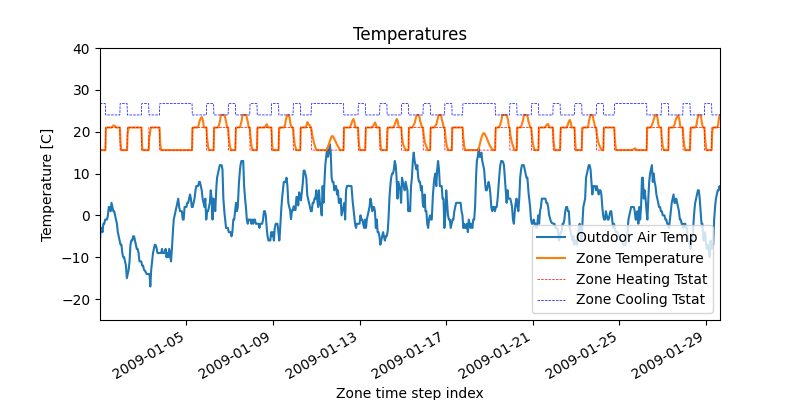

CPU times: user 1.86 s, sys: 75.9 ms, total: 1.94 s
Wall time: 1.97 s


In [24]:
%%time
x = []
y_outdoor = []
y_zone = []
y_htg = []
y_clg = []

years = []
months = []
days = []
hours = []
minutes = []
current_times = []
actual_date_times = []
actual_times = []

fig, ax = plt.subplots(figsize=(8, 4), num='Real time plot')
h1, = ax.plot(x, y_outdoor, label="Outdoor Air Temp")
h2, = ax.plot(x, y_zone, label="Zone Temperature")
h_htg, = ax.plot(x, y_htg, label='Zone Heating Tstat', linestyle='--', color='r', linewidth=0.5)
h_clg, = ax.plot(x, y_clg, label='Zone Cooling Tstat', linestyle='--', color='blue', linewidth=0.5)

ax.set_title('Temperatures')
ax.set_xlabel('Zone time step index')
ax.set_ylabel('Temperature [C]')
ax.legend(loc='lower right')
ax.set_ylim(-25, 40)
fig.autofmt_xdate()

# plt.show(False)
#plt.draw()
    

filename_to_run = 'test.idf'
zone_name = openstudio.model.getThermalZones(m)[0].nameString()
got_handles = False
oa_temp_handle = -1
zone_temp_handle = -1
zone_htg_tstat_handle = -1
zone_clg_tstat_handle = -1
count = 0
plot_update_interval = 250  # time steps

def update_line():
    
    
    #hl.set_data(x, y_outdoor)
    #h2.set_data(x, y_zone)
    
    h1.set_xdata(x)
    h1.set_ydata(y_outdoor)
    h2.set_xdata(x)
    h2.set_ydata(y_zone)
    h_htg.set_xdata(x)
    h_htg.set_ydata(y_htg)
    h_clg.set_xdata(x)
    h_clg.set_ydata(y_clg)
    
    ax.set_xlim(x[0], x[-1])
    #ax.set_ylim(min(y_outdoor + y_zone), max(y_outdoor + y_zone))
    #ax.autoscale_view()
    fig.canvas.draw()
    


def callback_function(state_argument):
    global count, got_handles, oa_temp_handle, zone_temp_handle, zone_htg_tstat_handle, zone_clg_tstat_handle
    if not got_handles:
        if not api.exchange.api_data_fully_ready(state_argument):
            return
        oa_temp_handle = api.exchange.get_variable_handle(state_argument, u"SITE OUTDOOR AIR DRYBULB TEMPERATURE", u"ENVIRONMENT")
        zone_temp_handle = api.exchange.get_variable_handle(state_argument, "Zone Mean Air Temperature", zone_name)
        zone_htg_tstat_handle = api.exchange.get_variable_handle(state_argument, "Zone Thermostat Heating Setpoint Temperature", zone_name)
        zone_clg_tstat_handle = api.exchange.get_variable_handle(state_argument, "Zone Thermostat Cooling Setpoint Temperature", zone_name)

        if -1 in [oa_temp_handle, zone_temp_handle, zone_htg_tstat_handle, zone_clg_tstat_handle]:
            
            print("***Invalid handles, check spelling and sensor/actuator availability")
            sys.exit(1)
        got_handles = True
    if api.exchange.warmup_flag(state_argument):
        return
    count += 1
    #x.append(count)
    oa_temp = api.exchange.get_variable_value(state_argument, oa_temp_handle)
    y_outdoor.append(oa_temp)
    zone_temp = api.exchange.get_variable_value(state_argument, zone_temp_handle)
    y_zone.append(zone_temp)
    
    zone_htg_tstat = api.exchange.get_variable_value(state_argument, zone_htg_tstat_handle)
    y_htg.append(zone_htg_tstat)
    
    zone_clg_tstat = api.exchange.get_variable_value(state_argument, zone_clg_tstat_handle)
    y_clg.append(zone_clg_tstat)
    
    
    year = api.exchange.year(state)
    month = api.exchange.month(state)
    day = api.exchange.day_of_month(state)
    hour = api.exchange.hour(state)
    minute = api.exchange.minutes(state)
    current_time = api.exchange.current_time(state)
    actual_date_time = api.exchange.actual_date_time(state)
    actual_time = api.exchange.actual_time(state)
                    
    # Year is bogus, seems to be reading the weather file year instead...         
    # So harcode it to 2009
    year = 2009
    years.append(year)
    months.append(month)
    days.append(day)
    hours.append(hour)
    minutes.append(minute)
    
    current_times.append(current_time)
    actual_date_times.append(actual_date_time)
    actual_times.append(actual_time)
    
    timedelta = datetime.timedelta()
    if hour >= 24.0:
        hour = 23.0
        timedelta += datetime.timedelta(hours=1)
    if minute >= 60.0:
        minute = 59
        timedelta += datetime.timedelta(minutes=1)
    
    dt = datetime.datetime(year=year, month=month, day=day, hour=hour, minute=minute)
    dt += timedelta
    x.append(dt)
    
    if count % plot_update_interval == 0:
        update_line()

api = EnergyPlusAPI()
state = api.state_manager.new_state()

api.runtime.callback_begin_zone_timestep_after_init_heat_balance(state, callback_function)
api.runtime.run_energyplus(state,
    [
        '-w', '/usr/local/EnergyPlus-9-4-0/WeatherData/USA_CO_Golden-NREL.724666_TMY3.epw',
        '-d', 'out',
        filename_to_run
    ]
)

# If you need to call run_energyplus again, then reset the state first
api.state_manager.reset_state(state)

## Plot with two graphs

<IPython.core.display.Javascript object>


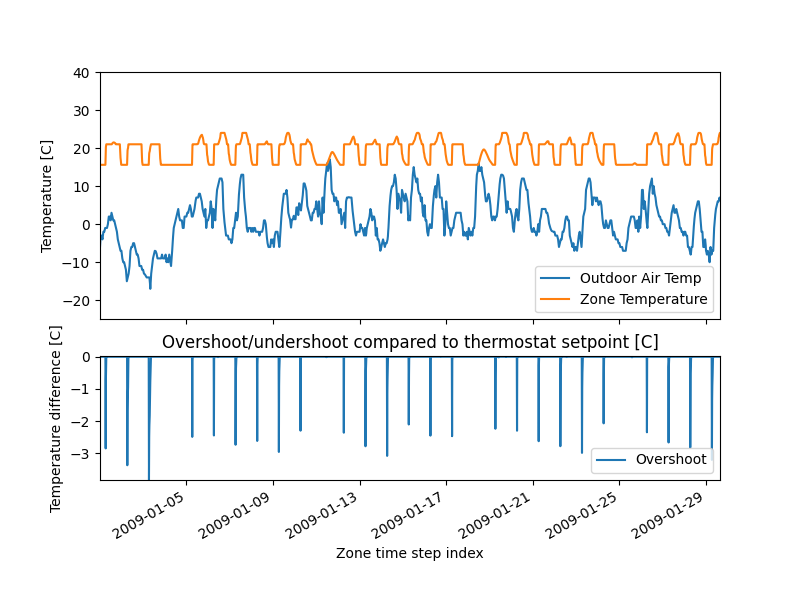

CPU times: user 2.04 s, sys: 95.8 ms, total: 2.13 s
Wall time: 2.13 s


In [25]:
%%time
x = []
y_outdoor = []
y_zone = []
y_htg = []
y_clg = []
y_overshoot = []

years = []
months = []
days = []
hours = []
minutes = []
current_times = []
actual_date_times = []
actual_times = []

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8, 6),
                               gridspec_kw={'height_ratios': [2, 1]},
                               num='Two graphs')
h1, = ax0.plot(x, y_outdoor, label="Outdoor Air Temp")
h2, = ax0.plot(x, y_zone, label="Zone Temperature")
h_overshoot, = ax1.plot(x, y_overshoot, label="Overshoot")

ax0.set_ylabel('Temperature [C]')
ax0.legend(loc='lower right')
ax0.set_ylim(-25, 40)

ax1.set_title('Overshoot/undershoot compared to thermostat setpoint [C]')
ax1.set_xlabel('Zone time step index')
ax1.set_ylabel('Temperature difference [C]')
ax1.legend(loc='lower right')
ax1.set_ylim(-1.1, 1.1)
# plt.show(False)
#plt.draw()
fig.autofmt_xdate()


filename_to_run = 'test.idf'
zone_name = openstudio.model.getThermalZones(m)[0].nameString()
got_handles = False
oa_temp_handle = -1
zone_temp_handle = -1
zone_htg_tstat_handle = -1
zone_clg_tstat_handle = -1
count = 0
plot_update_interval = 250  # time steps

def update_line():
    
    
    #hl.set_data(x, y_outdoor)
    #h2.set_data(x, y_zone)
    
    h1.set_xdata(x)
    h1.set_ydata(y_outdoor)
    h2.set_xdata(x)
    h2.set_ydata(y_zone)
    
    y_overshoot = []
    for i, zone_temp in enumerate(y_zone):
        if zone_temp < y_htg[i]:
            y_overshoot.append(zone_temp - y_htg[i])
        elif zone_temp > y_clg[i]:
            y_overshoot.append(zone_temp - y_clg[i])
        else:
            y_overshoot.append(0.0)
    
    h_overshoot.set_xdata(x)
    h_overshoot.set_ydata(y_overshoot)

    
    ax0.set_xlim(x[0], x[-1])
    ax1.set_ylim(min(y_overshoot), max(y_overshoot))
    #ax.autoscale_view()
    fig.canvas.draw()
    


def callback_function(state_argument):
    global count, got_handles, oa_temp_handle, zone_temp_handle, zone_htg_tstat_handle, zone_clg_tstat_handle
    if not got_handles:
        if not api.exchange.api_data_fully_ready(state_argument):
            return
        oa_temp_handle = api.exchange.get_variable_handle(state_argument, u"SITE OUTDOOR AIR DRYBULB TEMPERATURE", u"ENVIRONMENT")
        zone_temp_handle = api.exchange.get_variable_handle(state_argument, "Zone Mean Air Temperature", zone_name)
        zone_htg_tstat_handle = api.exchange.get_variable_handle(state_argument, "Zone Thermostat Heating Setpoint Temperature", zone_name)
        zone_clg_tstat_handle = api.exchange.get_variable_handle(state_argument, "Zone Thermostat Cooling Setpoint Temperature", zone_name)

        if -1 in [oa_temp_handle, zone_temp_handle, zone_htg_tstat_handle, zone_clg_tstat_handle]:
            
            print("***Invalid handles, check spelling and sensor/actuator availability")
            sys.exit(1)
        got_handles = True
    if api.exchange.warmup_flag(state_argument):
        return
    count += 1
    #x.append(count)
    oa_temp = api.exchange.get_variable_value(state_argument, oa_temp_handle)
    y_outdoor.append(oa_temp)
    zone_temp = api.exchange.get_variable_value(state_argument, zone_temp_handle)
    y_zone.append(zone_temp)
    
    zone_htg_tstat = api.exchange.get_variable_value(state_argument, zone_htg_tstat_handle)
    y_htg.append(zone_htg_tstat)
    
    zone_clg_tstat = api.exchange.get_variable_value(state_argument, zone_clg_tstat_handle)
    y_clg.append(zone_clg_tstat)
    
    
    year = api.exchange.year(state)
    month = api.exchange.month(state)
    day = api.exchange.day_of_month(state)
    hour = api.exchange.hour(state)
    minute = api.exchange.minutes(state)
    current_time = api.exchange.current_time(state)
    actual_date_time = api.exchange.actual_date_time(state)
    actual_time = api.exchange.actual_time(state)
                    
    # Year is bogus, seems to be reading the weather file year instead...         
    # So harcode it to 2009
    year = 2009
    years.append(year)
    months.append(month)
    days.append(day)
    hours.append(hour)
    minutes.append(minute)
    
    current_times.append(current_time)
    actual_date_times.append(actual_date_time)
    actual_times.append(actual_time)
    
    timedelta = datetime.timedelta()
    if hour >= 24.0:
        hour = 23.0
        timedelta += datetime.timedelta(hours=1)
    if minute >= 60.0:
        minute = 59
        timedelta += datetime.timedelta(minutes=1)
    
    dt = datetime.datetime(year=year, month=month, day=day, hour=hour, minute=minute)
    dt += timedelta
    x.append(dt)
    
    if count % plot_update_interval == 0:
        update_line()

api = EnergyPlusAPI()
state = api.state_manager.new_state()

api.runtime.callback_begin_zone_timestep_after_init_heat_balance(state, callback_function)
api.runtime.run_energyplus(state,
    [
        '-w', '/usr/local/EnergyPlus-9-4-0/WeatherData/USA_CO_Golden-NREL.724666_TMY3.epw',
        '-d', 'out',
        filename_to_run
    ]
)

# If you need to call run_energyplus again, then reset the state first
api.state_manager.reset_state(state)

## With pandas

In [26]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


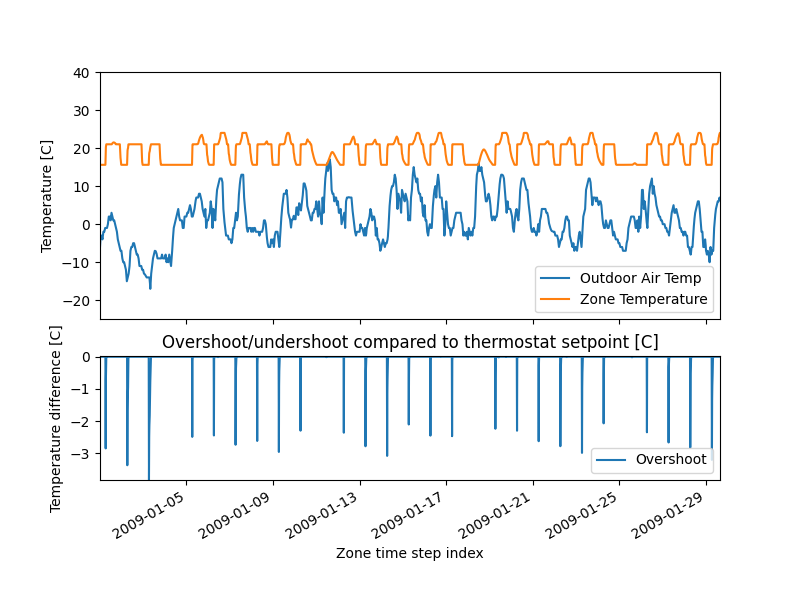

CPU times: user 1.96 s, sys: 80.8 ms, total: 2.04 s
Wall time: 2.03 s


In [27]:
%%time
x = []
y_outdoor = []
y_zone = []
y_htg = []
y_clg = []
y_overshoot = []
years = []
months = []
days = []
hours = []
minutes = []
current_times = []
actual_date_times = []
actual_times = []

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8, 6),
                               gridspec_kw={'height_ratios': [2, 1]},
                               num='Two graphs')
h1, = ax0.plot(x, y_outdoor, label="Outdoor Air Temp")
h2, = ax0.plot(x, y_zone, label="Zone Temperature")
h_overshoot, = ax1.plot(x, y_overshoot, label="Overshoot")

ax0.set_ylabel('Temperature [C]')
ax0.legend(loc='lower right')
ax0.set_ylim(-25, 40)

ax1.set_title('Overshoot/undershoot compared to thermostat setpoint [C]')
ax1.set_xlabel('Zone time step index')
ax1.set_ylabel('Temperature difference [C]')
ax1.legend(loc='lower right')
ax1.set_ylim(-1.1, 1.1)
# plt.show(False)
#plt.draw()
fig.autofmt_xdate()


filename_to_run = 'test.idf'
zone_name = openstudio.model.getThermalZones(m)[0].nameString()
got_handles = False
oa_temp_handle = -1
zone_temp_handle = -1
zone_htg_tstat_handle = -1
zone_clg_tstat_handle = -1
count = 0
plot_update_interval = 250  # time steps
df = None

def update_line():
    
    
    #hl.set_data(x, y_outdoor)
    #h2.set_data(x, y_zone)
    
    h1.set_xdata(df.index)
    h1.set_ydata(df['OA Temp'])
    h2.set_xdata(df.index)
    h2.set_ydata(df['Zone Temp'])
    
    
    y_overshoot = []
    for i, zone_temp in enumerate(y_zone):
        if zone_temp < y_htg[i]:
            y_overshoot.append(zone_temp - y_htg[i])
        elif zone_temp > y_clg[i]:
            y_overshoot.append(zone_temp - y_clg[i])
        else:
            y_overshoot.append(0.0)
    
    h_overshoot.set_xdata(df.index)
    h_overshoot.set_ydata(y_overshoot)

    
    ax0.set_xlim(x[0], x[-1])
    ax1.set_ylim(min(y_overshoot), max(y_overshoot))
    #ax.autoscale_view()
    fig.canvas.draw()
    


def callback_function(state_argument):
    
    if not hasattr(callback_function, "counter"):
        callback_function.counter = 0
        callback_function.index = []
    
    
    global count, got_handles, oa_temp_handle, zone_temp_handle, zone_htg_tstat_handle, zone_clg_tstat_handle, df
    if not got_handles:
        if not api.exchange.api_data_fully_ready(state_argument):
            return
        oa_temp_handle = api.exchange.get_variable_handle(state_argument, u"SITE OUTDOOR AIR DRYBULB TEMPERATURE", u"ENVIRONMENT")
        zone_temp_handle = api.exchange.get_variable_handle(state_argument, "Zone Mean Air Temperature", zone_name)
        zone_htg_tstat_handle = api.exchange.get_variable_handle(state_argument, "Zone Thermostat Heating Setpoint Temperature", zone_name)
        zone_clg_tstat_handle = api.exchange.get_variable_handle(state_argument, "Zone Thermostat Cooling Setpoint Temperature", zone_name)

        df = pd.DataFrame({'OA Temp': [], 'Zone Temp': [], 'Htg Tstat': [], 'Clg Tstat': []})
        
        if -1 in [oa_temp_handle, zone_temp_handle, zone_htg_tstat_handle, zone_clg_tstat_handle]:
            
            print("***Invalid handles, check spelling and sensor/actuator availability")
            sys.exit(1)
        got_handles = True
    
    if api.exchange.warmup_flag(state_argument):
        return
    
    
    count += 1
    callback_function.counter += 1
    
    #x.append(count)
    oa_temp = api.exchange.get_variable_value(state_argument, oa_temp_handle)
    y_outdoor.append(oa_temp)
    zone_temp = api.exchange.get_variable_value(state_argument, zone_temp_handle)
    y_zone.append(zone_temp)
    
    zone_htg_tstat = api.exchange.get_variable_value(state_argument, zone_htg_tstat_handle)
    y_htg.append(zone_htg_tstat)
    
    zone_clg_tstat = api.exchange.get_variable_value(state_argument, zone_clg_tstat_handle)
    y_clg.append(zone_clg_tstat)
    
    
    year = api.exchange.year(state)
    month = api.exchange.month(state)
    day = api.exchange.day_of_month(state)
    hour = api.exchange.hour(state)
    minute = api.exchange.minutes(state)
    current_time = api.exchange.current_time(state)
    actual_date_time = api.exchange.actual_date_time(state)
    actual_time = api.exchange.actual_time(state)
                    
    # Year is bogus, seems to be reading the weather file year instead...         
    # So harcode it to 2009
    year = 2009
    years.append(year)
    months.append(month)
    days.append(day)
    hours.append(hour)
    minutes.append(minute)
    
    current_times.append(current_time)
    actual_date_times.append(actual_date_time)
    actual_times.append(actual_time)
    
    timedelta = datetime.timedelta()
    if hour >= 24.0:
        hour = 23.0
        timedelta += datetime.timedelta(hours=1)
    if minute >= 60.0:
        minute = 59
        timedelta += datetime.timedelta(minutes=1)
    
    dt = datetime.datetime(year=year, month=month, day=day, hour=hour, minute=minute)
    dt += timedelta
    x.append(dt)
    
    # More explicit, but really slow
    # CPU times: user 8.78 s, sys: 128 ms, total: 8.9 s
    # Wall time: 8.9 s
    # df.loc[dt] = {'OA Temp': oa_temp, 'Zone Temp': zone_temp, 'Htg Tstat': zone_htg_tstat, 'Clg Tstat': zone_clg_tstat}
    
    # CPU times: user 6.66 s, sys: 128 ms, total: 6.79 s
    # Wall time: 6.77 s
    # df.loc[dt] = [oa_temp, zone_temp, zone_htg_tstat, zone_clg_tstat]
    
    # CPU times: user 6.56 s, sys: 100 ms, total: 6.66 s
    # Wall time: 6.65 s
    # s = pd.Series({'OA Temp': oa_temp, 'Zone Temp': zone_temp, 'Htg Tstat': zone_htg_tstat, 'Clg Tstat': zone_clg_tstat}, name=dt)
    # df = df.append(s)

    if count % plot_update_interval == 0:
        # df = pd.concat([df, pd.DataFrame()])
        # CPU times: user 2.09 s, sys: 84.2 ms, total: 2.18 s
        # Wall time: 2.17 s
#         df = pd.concat([df, pd.DataFrame({'OA Temp': y_outdoor[-plot_update_interval:],
#                                           'Zone Temp': y_zone[-plot_update_interval:],
#                                           'Htg Tstat': y_htg[-plot_update_interval:],
#                                           'Clg Tstat': y_clg[-plot_update_interval:]},
#                                          index=x[-plot_update_interval:])])
        # CPU times: user 2.1 s, sys: 56.4 ms, total: 2.15 s
        # Wall time: 2.14 s
        df = pd.DataFrame({'OA Temp': y_outdoor, 'Zone Temp': y_zone, 'Htg Tstat': y_htg, 'Clg Tstat': y_clg}, index=x)
        
        update_line()

api = EnergyPlusAPI()
state = api.state_manager.new_state()

api.runtime.callback_begin_zone_timestep_after_init_heat_balance(state, callback_function)
api.runtime.run_energyplus(state,
    [
        '-w', '/usr/local/EnergyPlus-9-4-0/WeatherData/USA_CO_Golden-NREL.724666_TMY3.epw',
        '-d', 'out',
        filename_to_run
    ]
)

# If you need to call run_energyplus again, then reset the state first
api.state_manager.reset_state(state)

## Use a class instead of globals

In [34]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [35]:
class TwoGraphs:
    def __init__(self, filename_to_run, zone_name):
        
        self.filename_to_run = filename_to_run
        self.zone_name = zone_name
        
        # Storing stuff
        self.got_handles = False
        self.oa_temp_handle = -1
        self.zone_temp_handle = -1
        self.zone_htg_tstat_handle = -1
        self.zone_clg_tstat_handle = -1
        self.count = 0
        self.plot_update_interval = 250  # time steps
        
        self.x = []
        self.y_outdoor = []
        self.y_zone = []
        self.y_htg = []
        self.y_clg = []
        self.y_overshoot = []
        self.years = []
        self.months = []
        self.days = []
        self.hours = []
        self.minutes = []
        self.current_times = []
        self.actual_date_times = []
        self.actual_times = []
        self.df = pd.DataFrame({'OA Temp': [], 'Zone Temp': [], 'Htg Tstat': [], 'Clg Tstat': []})


    def init_plot(self):

        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(8, 6),
                                       gridspec_kw={'height_ratios': [2, 1]},
                                       num='Two graphs')
        h1, = ax0.plot([], [], label="Outdoor Air Temp")
        h2, = ax0.plot([], [], label="Zone Temperature")
        h_overshoot, = ax1.plot([], [], label="Overshoot")

        ax0.set_ylabel('Temperature [C]')
        ax0.legend(loc='lower right')
        ax0.set_ylim(-25, 40)

        ax1.set_title('Overshoot/undershoot compared to thermostat setpoint [C]')
        ax1.set_xlabel('Zone time step index')
        ax1.set_ylabel('Temperature difference [C]')
        ax1.legend(loc='lower right')
        ax1.set_ylim(-1.1, 1.1)
        # plt.show(False)
        #plt.draw()
        fig.autofmt_xdate()
        
        # Store attributes
        self.fig = fig
        self.ax0 = ax0
        self.ax1 = ax1
        self.h1 = h1
        self.h2 = h2
        self.h_overshoot = h_overshoot

        fig.show()
        fig.canvas.draw()

    def update_line(self):


        #hl.set_data(x, y_outdoor)
        #h2.set_data(x, y_zone)

        self.h1.set_xdata(self.df.index)
        self.h1.set_ydata(self.df['OA Temp'])
        self.h2.set_xdata(self.df.index)
        self.h2.set_ydata(self.df['Zone Temp'])


        y_overshoot = []
        for i, zone_temp in enumerate(self.y_zone):
            if zone_temp < self.y_htg[i]:
                y_overshoot.append(zone_temp - self.y_htg[i])
            elif zone_temp > self.y_clg[i]:
                y_overshoot.append(zone_temp - self.y_clg[i])
            else:
                y_overshoot.append(0.0)

        self.h_overshoot.set_xdata(self.df.index)
        self.h_overshoot.set_ydata(y_overshoot)


        self.ax0.set_xlim(self.x[0], self.x[-1])
        #self.ax1.set_ylim(min(y_overshoot), max(y_overshoot))
        #ax.autoscale_view()
        self.fig.canvas.draw()
    

    def callback_function(self, state_argument):


        if not self.got_handles:
            if not api.exchange.api_data_fully_ready(state_argument):
                return
            self.oa_temp_handle = (
                api.exchange.get_variable_handle(state_argument, u"SITE OUTDOOR AIR DRYBULB TEMPERATURE", u"ENVIRONMENT")
            )
            self.zone_temp_handle = (
                api.exchange.get_variable_handle(state_argument, 
                                                 "Zone Mean Air Temperature",
                                                 self.zone_name)
            )
            self.zone_htg_tstat_handle = (
                api.exchange.get_variable_handle(state_argument,
                                                 "Zone Thermostat Heating Setpoint Temperature",
                                                 self.zone_name)
            )
            self.zone_clg_tstat_handle = (
                api.exchange.get_variable_handle(state_argument,
                                                 "Zone Thermostat Cooling Setpoint Temperature",
                                                 self.zone_name)
            )

            if -1 in [self.oa_temp_handle, self.zone_temp_handle,
                      self.zone_htg_tstat_handle, self.zone_clg_tstat_handle]:

                print("***Invalid handles, check spelling and sensor/actuator availability")
                sys.exit(1)
            self.got_handles = True
            self.init_plot()

        # Skip warmup
        if api.exchange.warmup_flag(state_argument):
            return


        self.count += 1

        oa_temp = api.exchange.get_variable_value(state_argument,
                                                  self.oa_temp_handle)
        self.y_outdoor.append(oa_temp)
        zone_temp = api.exchange.get_variable_value(state_argument,
                                                    self.zone_temp_handle)
        self.y_zone.append(zone_temp)

        zone_htg_tstat = api.exchange.get_variable_value(state_argument, 
                                                         self.zone_htg_tstat_handle)
        self.y_htg.append(zone_htg_tstat)

        zone_clg_tstat = api.exchange.get_variable_value(state_argument,
                                                         self.zone_clg_tstat_handle)
        self.y_clg.append(zone_clg_tstat)


        year = api.exchange.year(state)
        month = api.exchange.month(state)
        day = api.exchange.day_of_month(state)
        hour = api.exchange.hour(state)
        minute = api.exchange.minutes(state)
        current_time = api.exchange.current_time(state)
        actual_date_time = api.exchange.actual_date_time(state)
        actual_time = api.exchange.actual_time(state)

        # Year is bogus, seems to be reading the weather file year instead...         
        # So harcode it to 2009
        year = 2009
        self.years.append(year)
        self.months.append(month)
        self.days.append(day)
        self.hours.append(hour)
        self.minutes.append(minute)

        self.current_times.append(current_time)
        self.actual_date_times.append(actual_date_time)
        self.actual_times.append(actual_time)

        timedelta = datetime.timedelta()
        if hour >= 24.0:
            hour = 23.0
            timedelta += datetime.timedelta(hours=1)
        if minute >= 60.0:
            minute = 59
            timedelta += datetime.timedelta(minutes=1)

        dt = datetime.datetime(year=year, month=month, day=day, hour=hour, minute=minute)
        dt += timedelta
        self.x.append(dt)


        if self.count % self.plot_update_interval == 0:

            self.df = pd.DataFrame({'OA Temp': self.y_outdoor,
                                    'Zone Temp': self.y_zone,
                                    'Htg Tstat': self.y_htg,
                                    'Clg Tstat': self.y_clg},
                                   index=self.x)

            self.update_line()

<IPython.core.display.Javascript object>


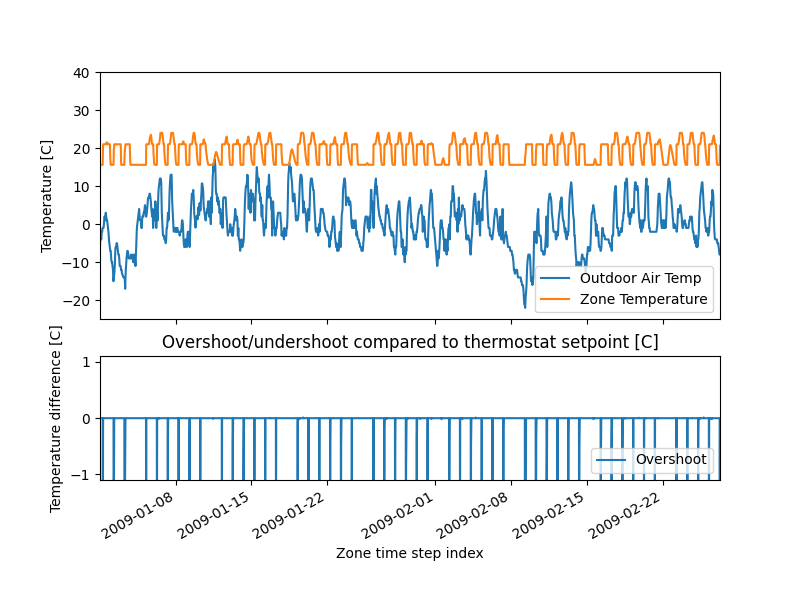

CPU times: user 3.88 s, sys: 99.2 ms, total: 3.98 s
Wall time: 3.99 s


In [45]:
%%time

api = EnergyPlusAPI()
state = api.state_manager.new_state()


filename_to_run = 'test.idf'
g = TwoGraphs(filename_to_run=filename_to_run,
              zone_name=openstudio.model.getThermalZones(m)[0].nameString())

api.runtime.callback_begin_zone_timestep_after_init_heat_balance(state, g.callback_function)
api.runtime.run_energyplus(state,
    [
        '-w', '/usr/local/EnergyPlus-9-4-0/WeatherData/USA_CO_Golden-NREL.724666_TMY3.epw',
        '-d', 'out',
        filename_to_run
    ]
)

# If you need to call run_energyplus again, then reset the state first
api.state_manager.reset_state(state)

### Post process example

And now I'm free to do whatever with the TwoGraphs instance that I used

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

#### Resampling

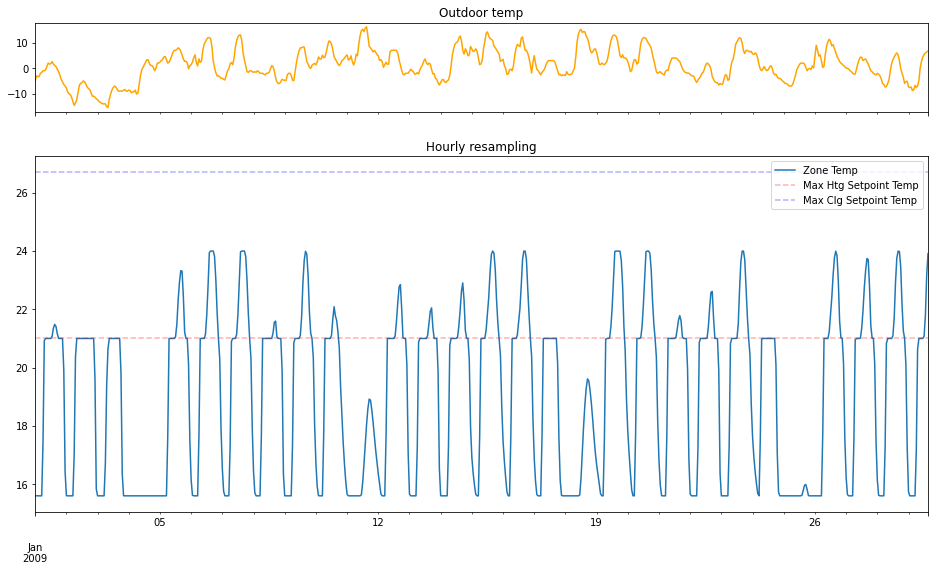

In [32]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True,
                       gridspec_kw={'height_ratios': [1, 4]},
                       figsize=(16, 9), num='Post process')

g.df['OA Temp'].resample('1H').mean().plot(ax=ax0, c='orange')
ax0.set_title('Outdoor temp')
g.df[['Zone Temp']].resample('1H').mean().plot(ax=ax1)
ax1.set_title('Hourly resampling')
ax1.axhline(g.df['Htg Tstat'].max(), linestyle='--', label='Max Htg Setpoint Temp', c='r', alpha=0.3)
ax1.axhline(g.df['Clg Tstat'].max(), linestyle='--', label='Max Clg Setpoint Temp', c='b', alpha=0.3)
ax1.legend(loc='best')

#### Truncation

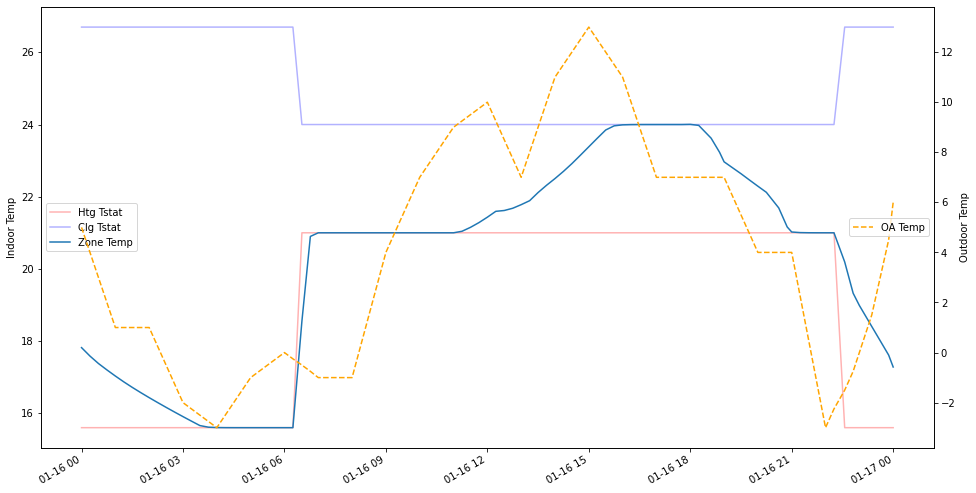

In [33]:
fig, ax = plt.subplots(figsize=(16, 9), num='Post process')

start='2009-01-16 00:00'
end='2009-01-17 00:00'

g.df[['Htg Tstat']].truncate(before=start, after=end).plot(ax=ax, c='r', alpha=0.3)
g.df[['Clg Tstat']].truncate(before=start, after=end).plot(ax=ax, c='b', alpha=0.3)
g.df[['Zone Temp']].truncate(before=start, after=end).plot(ax=ax)
ax.set_ylabel('Indoor Temp')
axbis = ax.twinx()
g.df['OA Temp'].truncate(before=start, after=end).plot(ax=axbis, c='orange', linestyle='--')
axbis.set_ylabel('Outdoor Temp')

ax.legend(loc='best')
axbis.legend(loc='right')